In [231]:
import sys

sys.path.append("../")

from pharynx_analysis import (pharynx_io as pio, image_processing as ip, experiment, plots)
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from importlib import reload
from skimage import measure, transform
from collections import namedtuple
import pdb
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy import ndimage as ndi

In [305]:
reload(pio);
reload(ip);
reload(experiment);

In [306]:
all_experiments_dir = Path('/home/sean/wormAnalysis/data/paired_ratios')

exp_dir = list(all_experiments_dir.iterdir())[2]
print(exp_dir)
img_path = str(exp_dir.joinpath(exp_dir.stem + '.tif'))
strain_map_path = str(exp_dir.joinpath(exp_dir.stem + '-indexer.csv'))
strains = pio.load_strain_map_from_disk(strain_map_path)

/home/sean/wormAnalysis/data/paired_ratios/2017_02_27-HD233_HD236


In [307]:
ex = experiment.PairExperiment(img_path, "TL/470/410/470/410", strains)

../pharynx_analysis/image_processing.py:258: RuntimeWarning: invalid value encountered in greater
  first = np.argmax(profile > threshold)
../pharynx_analysis/image_processing.py:259: RuntimeWarning: invalid value encountered in greater
  last = len(profile) - np.argmax(np.flip(profile > threshold))
/home/sean/.local/share/virtualenvs/python-9A8iwiI2/lib/python3.7/site-packages/xarray/core/computation.py:564: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


/home/sean/.local/share/virtualenvs/python-9A8iwiI2/lib/python3.7/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/sean/.local/share/virtualenvs/python-9A8iwiI2/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


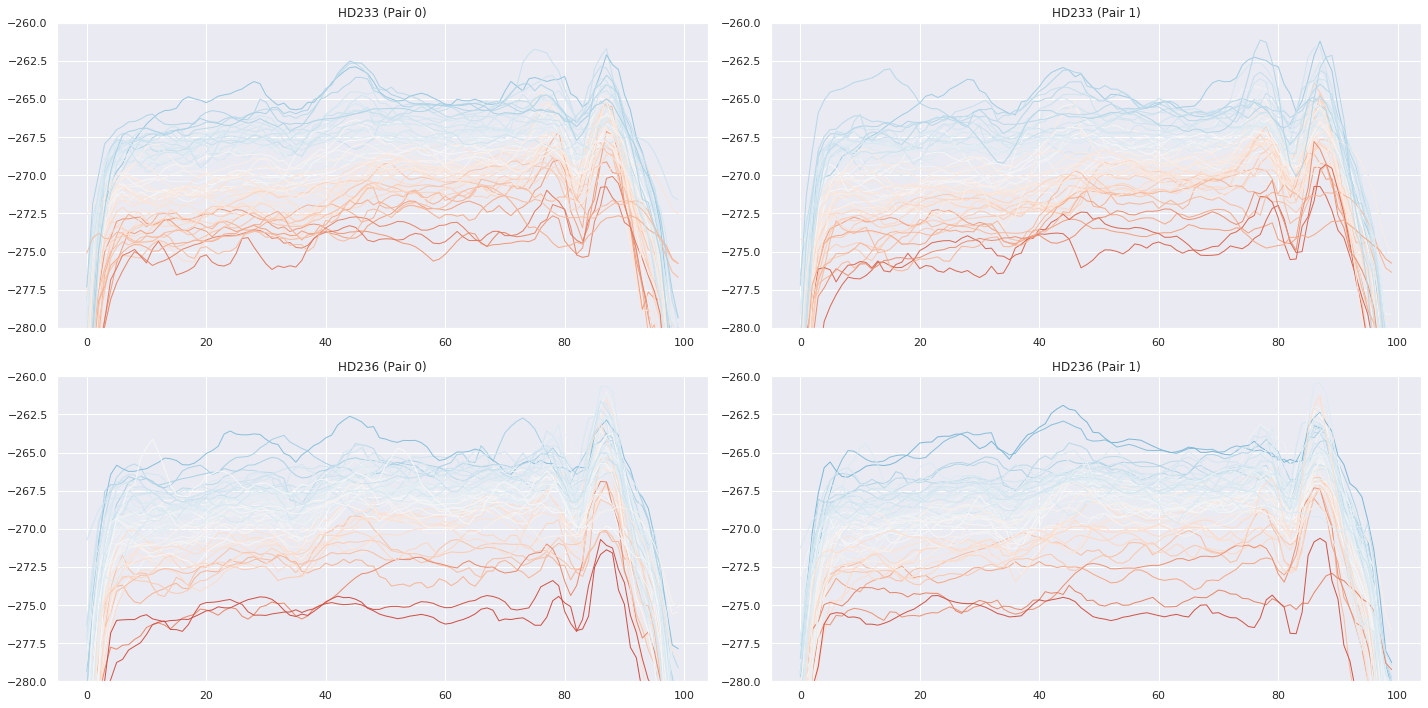

In [308]:
plots.plot_individual_profile_data_by_strain_and_pair(
    ex.e, cmin=-280, cmax=-260, cmap_name='RdBu',
    ylim=[-280, -260], figsize=(20,10)
)

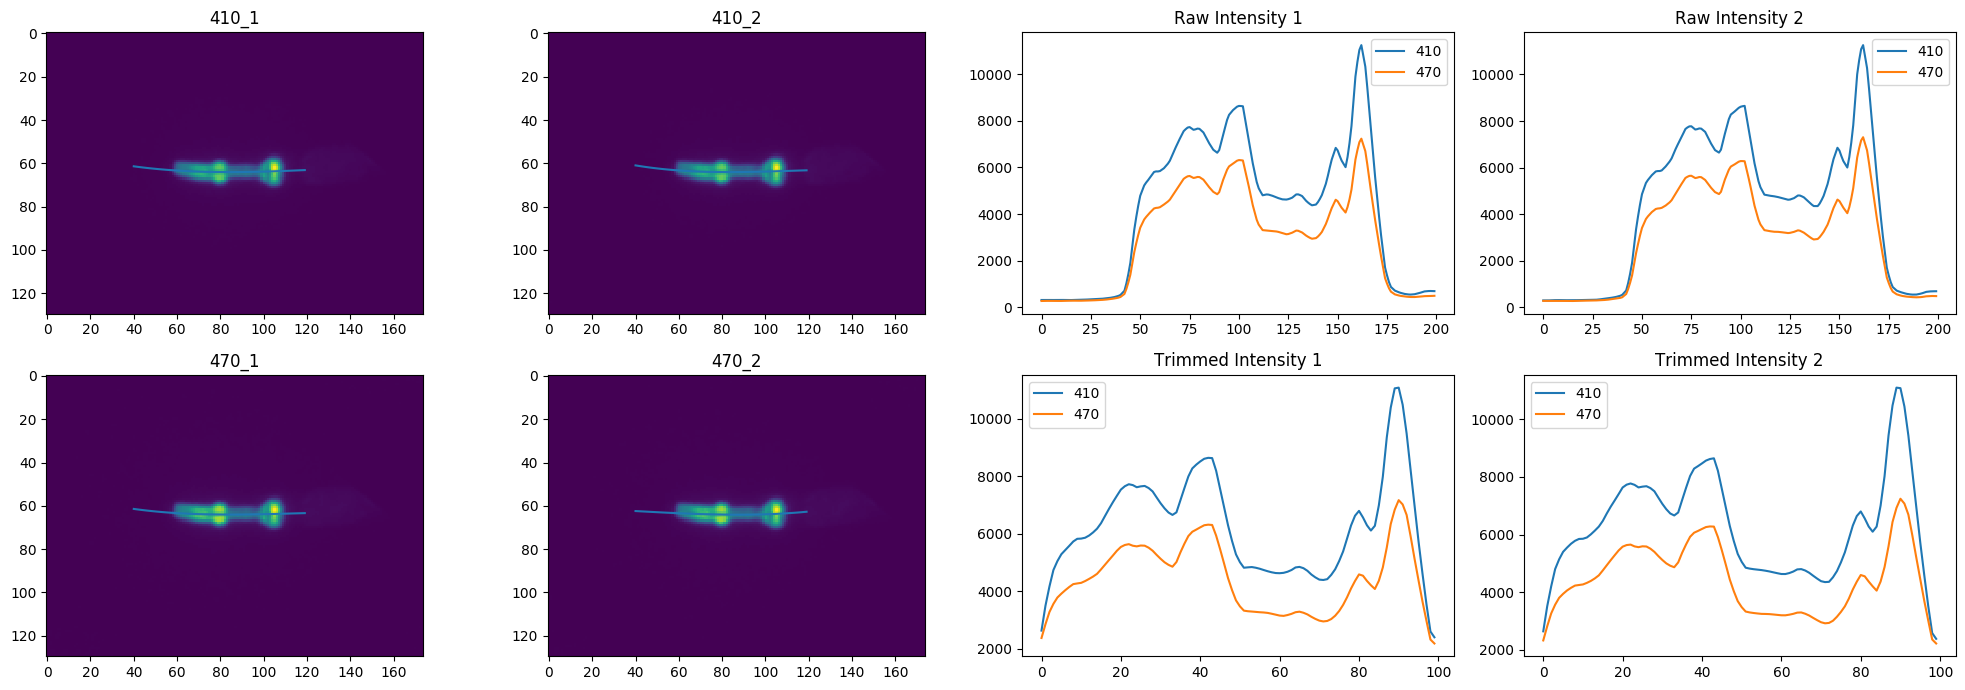

In [374]:
i = 1

fig, axes = plt.subplots(2,4,figsize=(20,7))

# IMAGES

# 410_1
ax = axes[0, 0]
xs = np.arange(40,120)
ax.imshow(ex.rot_fl.sel(wavelength='410', pair=0).isel(strain=i))
ax.plot(xs, ex.midlines[i]['410'][0](xs))
ax.set_title('410_1')

# 410_2
ax = axes[0, 1]
xs = np.arange(40,120)
ax.imshow(ex.rot_fl.sel(wavelength='410', pair=1).isel(strain=i))
ax.plot(xs, ex.midlines[i]['410'][1](xs))
ax.set_title('410_2')

# 470_1
ax = axes[1,0]
xs = np.arange(40,120)
ROW = 1
ax.imshow(ex.rot_fl.sel(wavelength='470', pair=0).isel(strain=i))
ax.plot(xs, ex.midlines[i]['470'][0](xs))
ax.set_title('470_1')

# 470_2
ax = axes[1,1]
xs = np.arange(40,120)
ax.imshow(ex.rot_fl.sel(wavelength='470', pair=1).isel(strain=i))
ax.plot(xs, ex.midlines[i]['470'][1](xs))
ax.set_title('470_2')


# # PLOTS
ax = axes[0,2]
wvl = '410'
pair = 0
ax.plot(ex.raw_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

wvl = '470'
pair = 0
ax.plot(ex.raw_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

ax.legend()
ax.set_title(f'Raw Intensity {pair+1}')

ax = axes[0,3]
wvl = '410'
pair = 1
ax.plot(ex.raw_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

wvl = '470'
pair = 1
ax.plot(ex.raw_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

ax.legend()
ax.set_title(f'Raw Intensity {pair+1}')

# # TRIMMED
ax = axes[1,2]
wvl = '410'
pair = 0
ax.plot(ex.trimmed_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

wvl = '470'
pair = 0
ax.plot(ex.trimmed_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

ax.legend()
ax.set_title(f'Trimmed Intensity {pair+1}')

ax = axes[1,3]
wvl = '410'
pair = 1
ax.plot(ex.trimmed_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

wvl = '470'
pair = 1
ax.plot(ex.trimmed_intensity_data.sel(wavelength=wvl, pair=pair).isel(strain=i), label=f'{wvl}')

ax.legend()
ax.set_title(f'Trimmed Intensity {pair+1}')

plt.tight_layout()
# plt.savefig('/home/sean/Desktop/example.pdf')

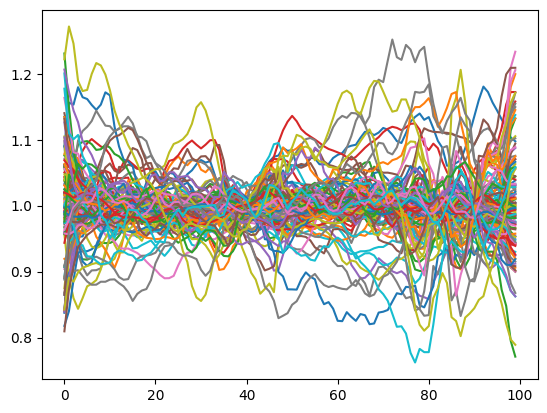

In [380]:
r_of_r = (
    ex.trimmed_intensity_data.sel(wavelength='410', pair=0) / ex.trimmed_intensity_data.sel(wavelength='470', pair=0)
) / (ex.trimmed_intensity_data.sel(wavelength='410', pair=0) / ex.trimmed_intensity_data.sel(wavelength='470', pair=1))

plt.plot(r_of_r.T);

In [381]:
r_of_r

<xarray.DataArray (strain: 120, position: 100)>
array([[0.837653, 0.942126, 0.98926 , ..., 1.119123, 1.103264, 1.097556],
       [0.981415, 0.989424, 0.997046, ..., 1.018509, 1.018989, 1.019153],
       [0.99817 , 0.99878 , 0.994659, ..., 0.984018, 0.983814, 0.984569],
       ...,
       [0.888026, 0.962217, 0.993099, ..., 0.979048, 0.954706, 0.944936],
       [1.221844, 1.271599, 1.245721, ..., 0.994586, 1.040813, 1.056177],
       [1.177323, 1.109843, 1.100659, ..., 1.022262, 1.04893 , 1.058227]])
Coordinates:
  * strain   (strain) object 'HD233' 'HD233' 'HD233' ... 'HD236' 'HD236' 'HD236'
    pair     int64 0
Dimensions without coordinates: position

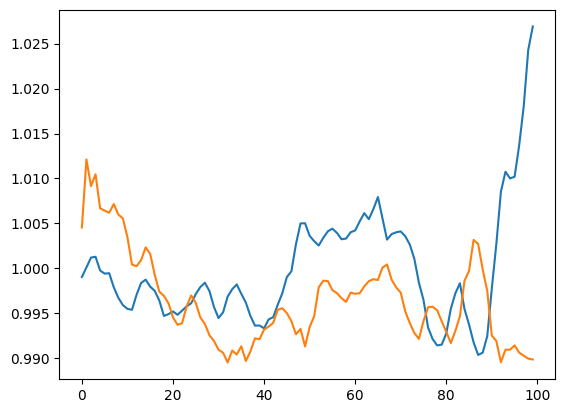

In [385]:
plt.plot(r_of_r.sel(strain='HD233').mean(dim='strain'))
plt.plot(r_of_r.sel(strain='HD236').mean(dim='strain'))